# FIG CESM run evaluations

In [1]:
import os
import sys
import yaml
import argparse
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
#import verif_utils as vu

In [2]:
import pandas as pd

In [3]:
import matplotlib.dates as mdates

In [4]:
import cmaps
# graph tools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.colorbar as cbar
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

In [5]:
import matplotlib.lines as mlines

In [6]:
fig_keys = {
    'dpi': 150, 
    'orientation':'portrait', 
    'bbox_inches':'tight', 
    'pad_inches':0.1, 
    'transparent':False
}

In [62]:
need_publish = False

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [8]:
from numpy.lib.stride_tricks import sliding_window_view

def moving_average_axis(a, window, axis=-1, pad_mode="reflect"):
    a = np.asarray(a, dtype=float)
    if window < 1:
        raise ValueError("window must be >= 1")

    # asymmetric split works for even/odd windows
    pad_left  = (window - 1) // 2
    pad_right =  window // 2

    # Build pad widths for all axes; pad only along the chosen axis
    pad_widths = [(0, 0)] * a.ndim
    pad_widths[axis] = (pad_left, pad_right)

    apad = np.pad(a, pad_widths, mode=pad_mode)

    # Sliding windows along `axis`, then average over the last dim (window)
    sw = sliding_window_view(apad, window_shape=window, axis=axis)
    return sw.mean(axis=-1)

## Prep data

In [9]:
flag_first_time = True

varname_pick = ['WRF_T2', 'WRF_T', 'WRF_U10', 'WRF_U', 'WRF_V10', 'WRF_V', 'WRF_PWAT', 'WRF_Q_tot']
varname_plot = ['WRF_T2', 'WRF_T', 'WRF_SPD10', 'WRF_SPD', 'WRF_PWAT', 'WRF_Q_tot']

if flag_first_time:
    dict_RMSE = {}

for exp_name in ['B3H', 'B6H', 'GDAS']:

    if flag_first_time:
        ds_collection = []
        for year in range(2021, 2025):
            rmse_ds = xr.open_zarr(f'/glade/campaign/ral/hap/ksha/GWC_results/scores/RMSE/RMSE_{exp_name}_{year}.zarr')
            rmse_ds = rmse_ds[varname_pick].isel(bottom_top=5) # 5
            # rmse_ds = rmse_ds.chunk(dict(time=-1))
            ds_collection.append(rmse_ds)
            
        ds_RMSE = xr.concat(ds_collection, dim='time')
        
        ds_RMSE['WRF_SPD10'] = 0.5*ds_RMSE['WRF_U10'] + 0.5*ds_RMSE['WRF_V10']
        ds_RMSE['WRF_SPD'] = 0.5*ds_RMSE['WRF_U'] + 0.5*ds_RMSE['WRF_V']
        ds_RMSE = ds_RMSE.drop_vars(['WRF_U10', 'WRF_U', 'WRF_V10', 'WRF_V'])

    for i_var, varname in enumerate(varname_plot):
        if flag_first_time:
            dict_RMSE[f'{exp_name}_{varname}'] = ds_RMSE[varname].values
            
        dict_RMSE[f'{exp_name}_{varname}_ave'] = moving_average_axis(dict_RMSE[f'{exp_name}_{varname}'], 30*24, axis=0)
        dict_RMSE[f'{exp_name}_{varname}_mean'] = dict_RMSE[f'{exp_name}_{varname}'].mean()
        dict_RMSE[f'{exp_name}_{varname}_std'] = dict_RMSE[f'{exp_name}_{varname}'].std()

In [10]:
time_hourly = ds_RMSE['time'].values

In [12]:
dict_ZES = {}

for exp_name in ['B3H', 'B6H', 'GDAS', 'target']:
    fn = f'/glade/campaign/ral/hap/ksha/GWC_results/scores/ZES/ZES_FFT_{exp_name}.zarr'
    ds = xr.open_zarr(fn)
    
    ds = ds.rename({'WRF_U': 'WRF_SPD', 'WRF_U10': 'WRF_SPD10'})

    varname_keep = list(ds.keys())
    # ZES = ds.mean(['latitude'])
    wavelength = ds['wavelength_km'].values * 1e3 # km to m
    # wavelength_mean = np.abs(wavelength.mean(axis=1))
    dict_ZES[f'{exp_name}_lambda'] = wavelength


    for varname in varname_keep:
        ZES_np = np.abs(ds[varname].values)
        dict_ZES[f'{exp_name}_{varname}_zes'] = ZES_np
    

## Plot

In [13]:
my_colors = gu.ksha_color_set_summon(color_set=0)
cyan = my_colors['cyan']
blue = my_colors['blue']
red = my_colors['red']
orange = my_colors['orange']

In [14]:
line_keys = {}
line_keys['B3H'] = {'linewidth': 3, 'linestyle': '--', 'color': blue, 'alpha': 1, 'zorder': 3, 'label': ''}
line_keys['B6H'] = {'linewidth': 3, 'linestyle': '--', 'color': red, 'alpha': 1, 'zorder': 4, 'label': ''}
line_keys['GDAS'] = {'linewidth': 3, 'linestyle': '-', 'color': orange, 'alpha': 1, 'zorder': 2, 'label': ''}
line_keys['target'] = {'linewidth': 2.5, 'linestyle': '--', 'color': 'k', 'alpha': 1, 'zorder': 1, 'label': ''}

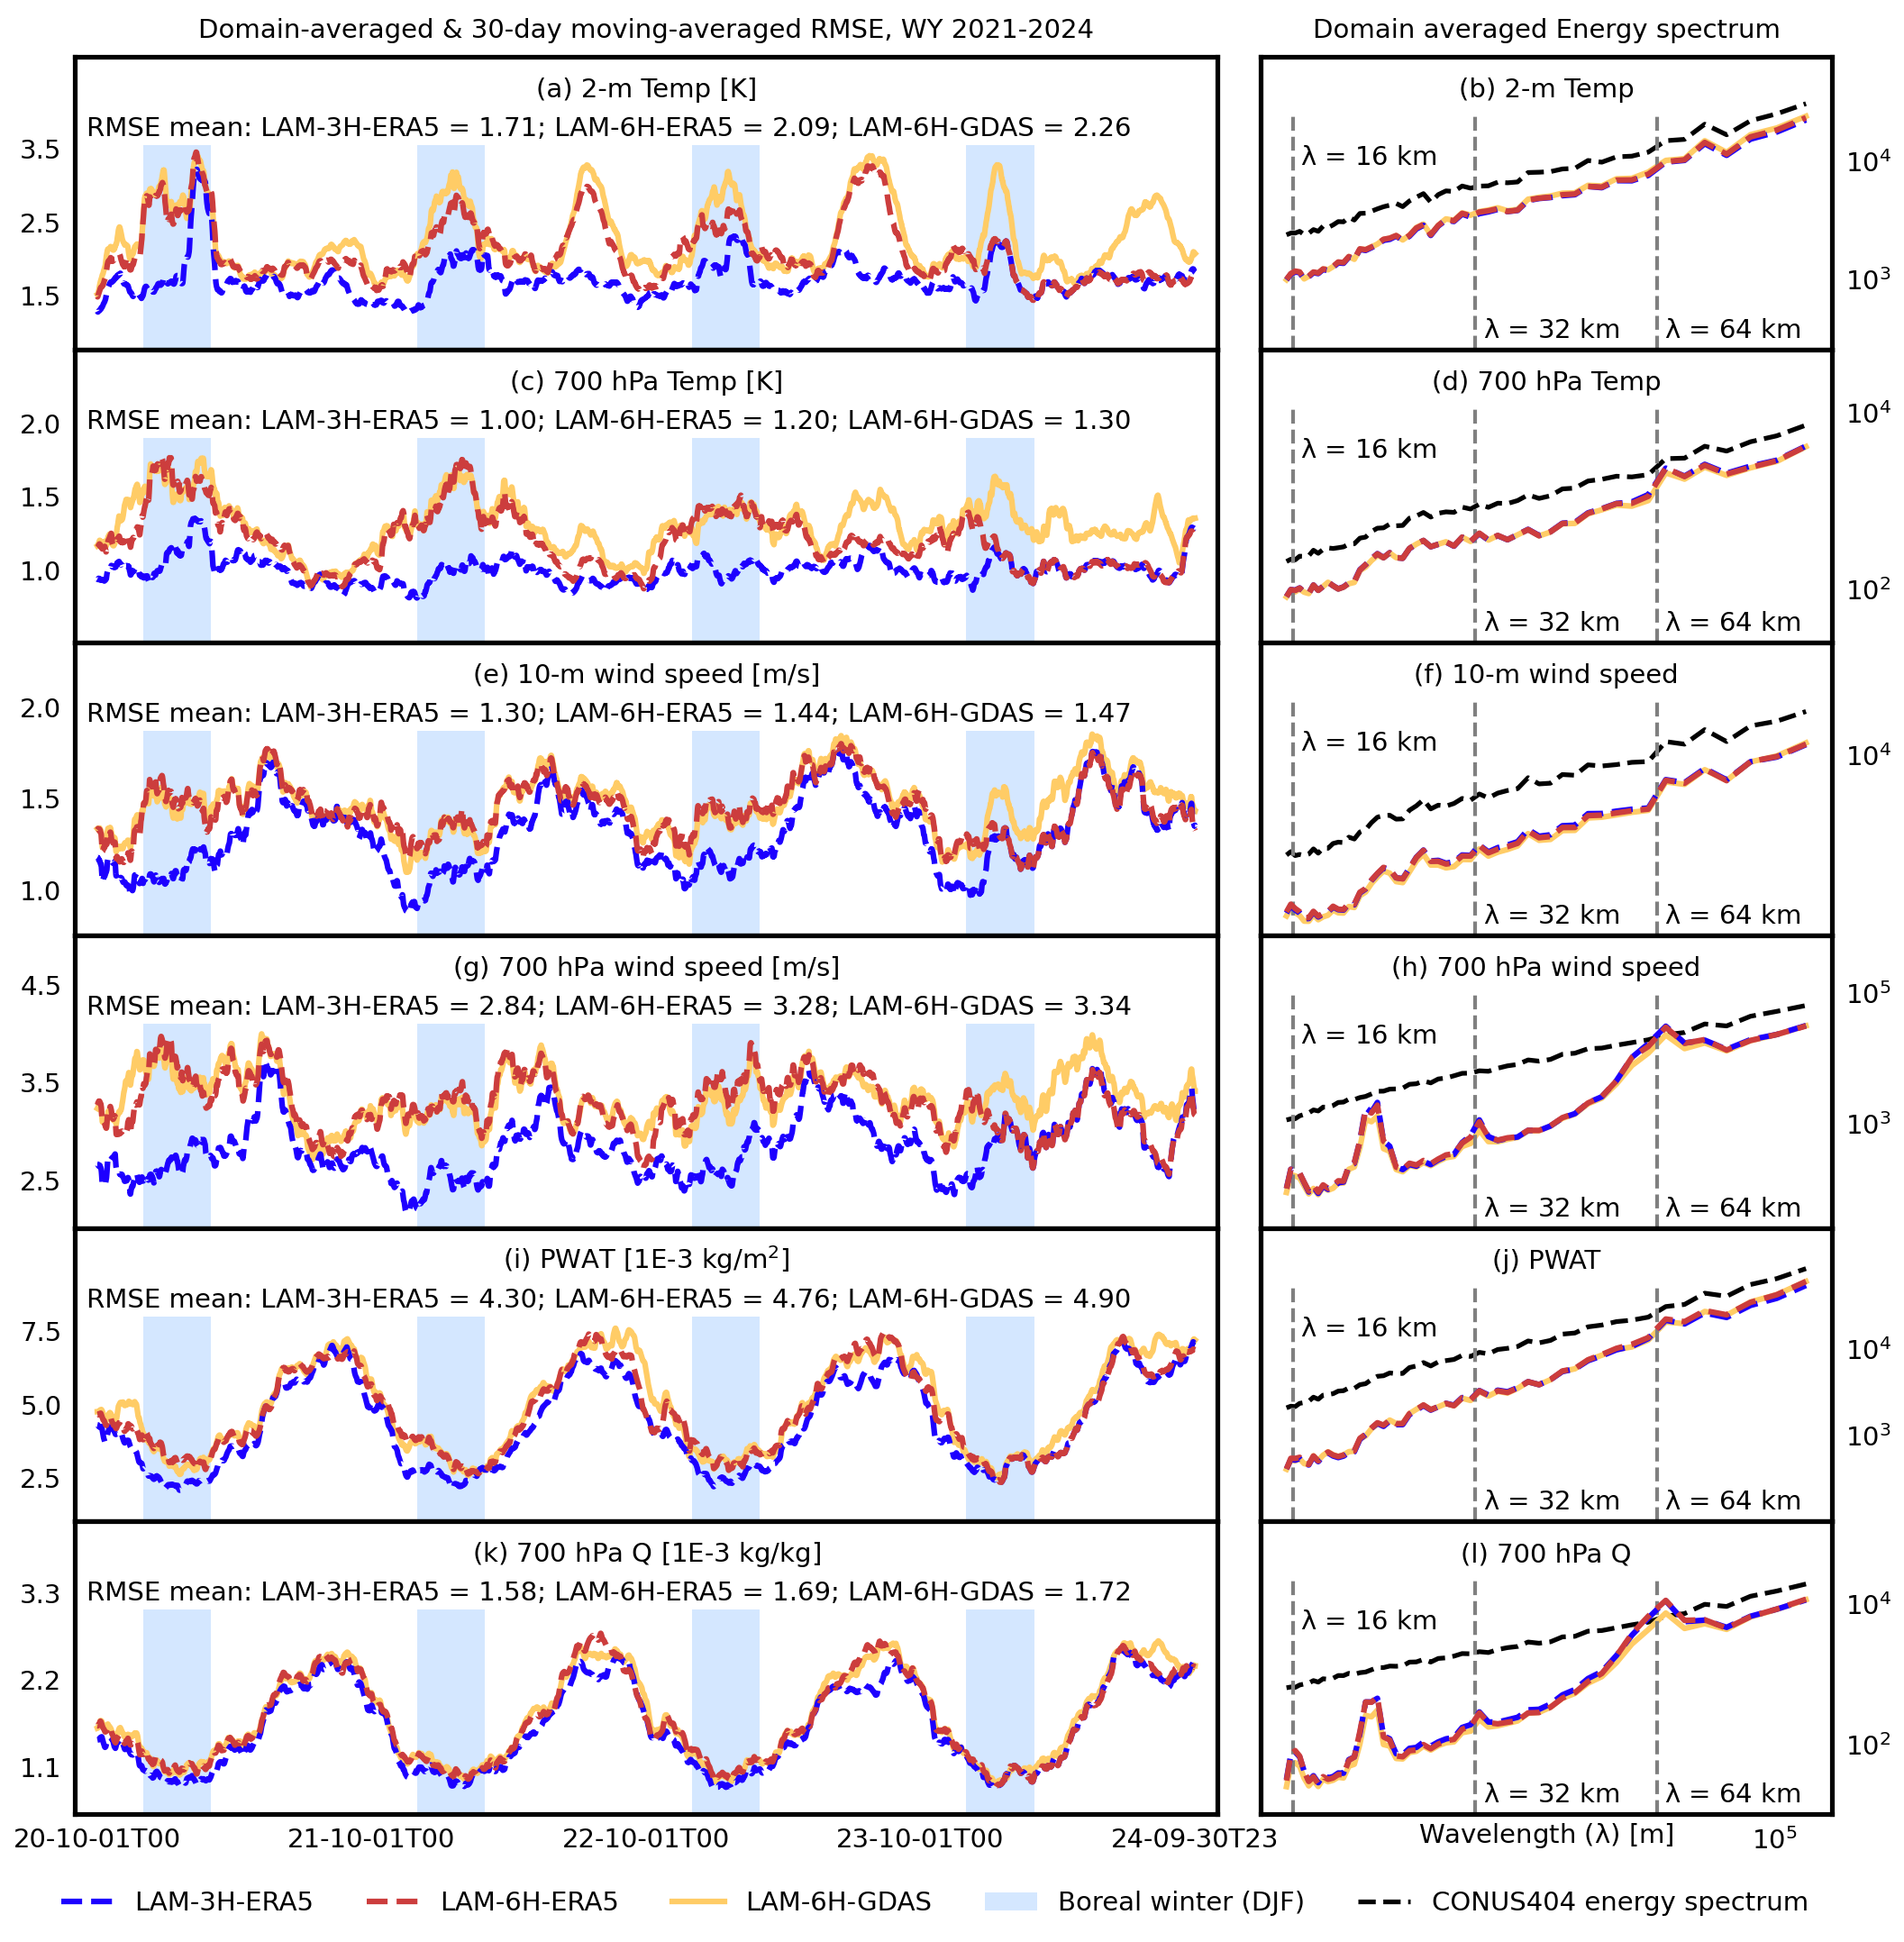

In [63]:
fig = plt.figure(figsize=(13, 13), dpi=dpi_)
gs = gridspec.GridSpec(6, 2, height_ratios=[1,]*6, width_ratios=[1, 0.5])

AX_lines = []
AX_zes = []
for i in range(6):
    AX_lines.append(plt.subplot(gs[i, 0]))
    AX_zes.append(plt.subplot(gs[i, 1]))

for ax in AX_zes + AX_lines:
    ax = gu.ax_decorate_box(ax)

for ax in AX_lines:
    ax.tick_params(labelleft=True, labelsize=14)

AX_lines[-1].tick_params(labelbottom=True, labelsize=14)

for ax in AX_zes:
    ax.tick_params(labelright=True, labelsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')

AX_zes[-1].tick_params(labelbottom=True, labelsize=14)

# plt.subplots_adjust(0, 0, 1, 1, hspace=0.2, wspace=0.05)
plt.subplots_adjust(0, 0, 1, 1, hspace=0., wspace=0.05)

title_lines = [
    '(a) 2-m Temp [K]', 
    '(c) 700 hPa Temp [K]', 
    '(e) 10-m wind speed [$\mathsf{m/s}$]',
    '(g) 700 hPa wind speed [$\mathsf{m/s}$]',
    '(i) PWAT [1E-3 $\mathsf{kg/m^{2}}$]', # $\mathsf{10^{-3}}$ 
    '(k) 700 hPa Q [1E-3 $\mathsf{kg/kg}$]'
]


title_zes = [
    '(b) 2-m Temp', 
    '(d) 700 hPa Temp', 
    '(f) 10-m wind speed',
    '(h) 700 hPa wind speed',
    '(j) PWAT',
    '(l) 700 hPa Q'
]

scales = [1, 1, 1, 1, 1e3, 1e3]
YLIMs = [[0.75, 4.75], [0.5, 2.5], [0.75, 2.35], [2, 5], [1, 11], [0.5, 4.2]]
YTICKS = [
    [1.5, 2.5, 3.5], [1.0, 1.5, 2.0],
    [1, 1.5, 2,], [2.5, 3.5, 4.5],
    [2.5, 5.0, 7.5], [1.1, 2.2, 3.3]
]

X_TICKS = np.array([
    np.datetime64('2020-10-01T00'),
    np.datetime64('2021-10-01T00'), 
    np.datetime64('2022-10-01T00'), 
    np.datetime64('2023-10-01T00'), 
    np.datetime64('2024-09-30T23')])

for i_var, varname in enumerate(varname_plot):
    for i_exp, exp_name in enumerate(['B3H', 'B6H', 'GDAS']):

        temp_mean = []
        temp_std = []
        
        AX_lines[i_var].plot(time_hourly, scales[i_var]*dict_RMSE[f'{exp_name}_{varname}_ave'], **line_keys[exp_name])

    AX_lines[i_var].axvspan(
        np.datetime64('2020-12-01T00'),
        np.datetime64('2021-03-01T00'), 
        color=cyan, linewidth=0, alpha=0.25, ymin=0, ymax=0.7, zorder=1)

    AX_lines[i_var].axvspan(
        np.datetime64('2021-12-01T00'),
        np.datetime64('2022-03-01T00'), 
        color=cyan, linewidth=0, alpha=0.25, ymin=0, ymax=0.7, zorder=1)

    AX_lines[i_var].axvspan(
        np.datetime64('2022-12-01T00'),
        np.datetime64('2023-03-01T00'), 
        color=cyan, linewidth=0, alpha=0.25, ymin=0, ymax=0.7, zorder=1)

    AX_lines[i_var].axvspan(
        np.datetime64('2023-12-01T00'),
        np.datetime64('2024-03-01T00'), 
        color=cyan, linewidth=0, alpha=0.25, ymin=0, ymax=0.7, zorder=1)
    
    AX_lines[i_var].text(
        0.01, 0.8, 
        'RMSE mean: LAM-3H-ERA5 = {:.2f}; LAM-6H-ERA5 = {:.2f}; LAM-6H-GDAS = {:.2f}'.format(
            scales[i_var]*dict_RMSE[f'B3H_{varname}_mean'], 
            scales[i_var]*dict_RMSE[f'B6H_{varname}_mean'], 
            scales[i_var]*dict_RMSE[f'GDAS_{varname}_mean']),
    fontsize=14, ha='left', va='top', transform=AX_lines[i_var].transAxes)
    
    AX_lines[i_var].set_title(title_lines[i_var], fontsize=14, y=0.825)
    AX_lines[i_var].set_ylim(YLIMs[i_var])
    AX_lines[i_var].set_yticks(YTICKS[i_var])
    # AX_lines[i_var].set_xlim([time_hourly[0], time_hourly[-1]])
    AX_lines[i_var].set_xlim([np.datetime64('2020-09-01T00'), np.datetime64('2024-10-30T23')])
    
    if i_var == 5:
        AX_lines[i_var].set_xticks(X_TICKS)
        
        AX_lines[i_var].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%dT%H'))
        # AX_lines[i_var].tick_params(axis='x', labelrotation=45)

# for i in range(2):
#     AX_lines[4+i].text(0.01, 0.92, '[1E-3]', fontsize=14, ha='left', va='top', transform=AX_lines[4+i].transAxes)


# YLIMs = [[1e3, 7.5e5], [1e3, 5e5], [1e3, 7.5e5], [2e3, 2e6], [1e-2, 2e0], [3e-4, 9e-1]]
# YTICKS = [
#     [1e4, 1e5], [1e4, 1e5],
#     [1e4, 1e5], [1e4, 1e5],
#     [1e-1, 1e0], [1e-3, 1e-2, 1e-1]
# ]

YLIMs = [[2.5e2, 7.5e4], [2.5e1, 5e4], [7.5e2, 5e4], [2.5e1, 7.5e5], [1e2, 2.5e5], [1e1, 1.5e5]]
YTICKS = [
    [1e3, 1e4], [1e2, 1e4],
    [1e4], [1e3, 1e5],
    [1e3, 1e4], [1e2, 1e4]
]

X_VLIME = [16000, 32000, 64000]

for i_var, varname in enumerate(varname_plot):
    for exp_name in ['B3H', 'B6H', 'GDAS', 'target']:
        # cut too small and too big wavelength
        AX_zes[i_var].plot(
            dict_ZES[f'{exp_name}_lambda'][106:-8], 
            dict_ZES[f'{exp_name}_{varname}_zes'][106:-8], **line_keys[exp_name])

    AX_zes[i_var].set_ylim(YLIMs[i_var])
    AX_zes[i_var].set_yticks(YTICKS[i_var])
    AX_zes[i_var].set_title(title_zes[i_var], fontsize=14, y=0.825)
    
    # AX_zes[i_var].set_ylabel('Spectral power', fontsize=14)
    # AX_zes[i_var].yaxis.set_label_position("right")
    
    for x_vline in X_VLIME:
        AX_zes[i_var].axvline(x=x_vline, color='0.5', linestyle='--', linewidth=2, ymin=0.0, ymax=0.8)

    AX_zes[i_var].text(
        0.07, 0.7, '$\mathsf{\lambda}$ = 16 km', 
        ha='left', va='top', fontsize=14, transform=AX_zes[i_var].transAxes)

    AX_zes[i_var].text(
        0.375+0.015, 0.025, '$\mathsf{\lambda}$ = 32 km', 
        ha='left', va='bottom', fontsize=14, transform=AX_zes[i_var].transAxes)

    AX_zes[i_var].text(
        0.681+0.025, 0.024, '$\mathsf{\lambda}$ = 64 km', 
        ha='left', va='bottom', fontsize=14, transform=AX_zes[i_var].transAxes)

AX_zes[-1].set_xlabel('Wavelength ($\mathsf{\lambda}$) [m]', fontsize=14, labelpad=-18)

ax_title1 = fig.add_axes([0.0, 1.005, 0.65, 0.02])
ax_title1.text(
    0.5, 0.5, 
    'Domain-averaged & 30-day moving-averaged RMSE, '
    'WY 2021-2024',
    fontsize=14, va='center', ha='center', transform=ax_title1.transAxes
)


ax_title2 = fig.add_axes([0.675, 1.005, 0.325, 0.02])
ax_title2.text(
    0.5, 0.5, 
    'Domain averaged Energy spectrum',
    fontsize=14, va='center', ha='center', transform=ax_title2.transAxes
)

handle_legneds1 = []
handle_legneds1.append(mlines.Line2D([], [], **line_keys['B3H']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['B6H']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['GDAS']))
handle_legneds1.append(patches.Patch(facecolor=cyan, alpha=0.25, linewidth=0, label=' '))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['target']))

ax_lg1 = fig.add_axes([0, -0.065, 1.0, 0.035])
LG1 = ax_lg1.legend(
    handle_legneds1, 
    ['LAM-3H-ERA5', 'LAM-6H-ERA5', 'LAM-6H-GDAS', 'Boreal winter (DJF)', 'CONUS404 energy spectrum',], 
    bbox_to_anchor=(1, 1), ncol=5, prop={'size':14}
)

LG1 = gu.lg_box(LG1)
ax_title1.set_axis_off()
ax_title2.set_axis_off()
ax_lg1.set_axis_off()

### Old

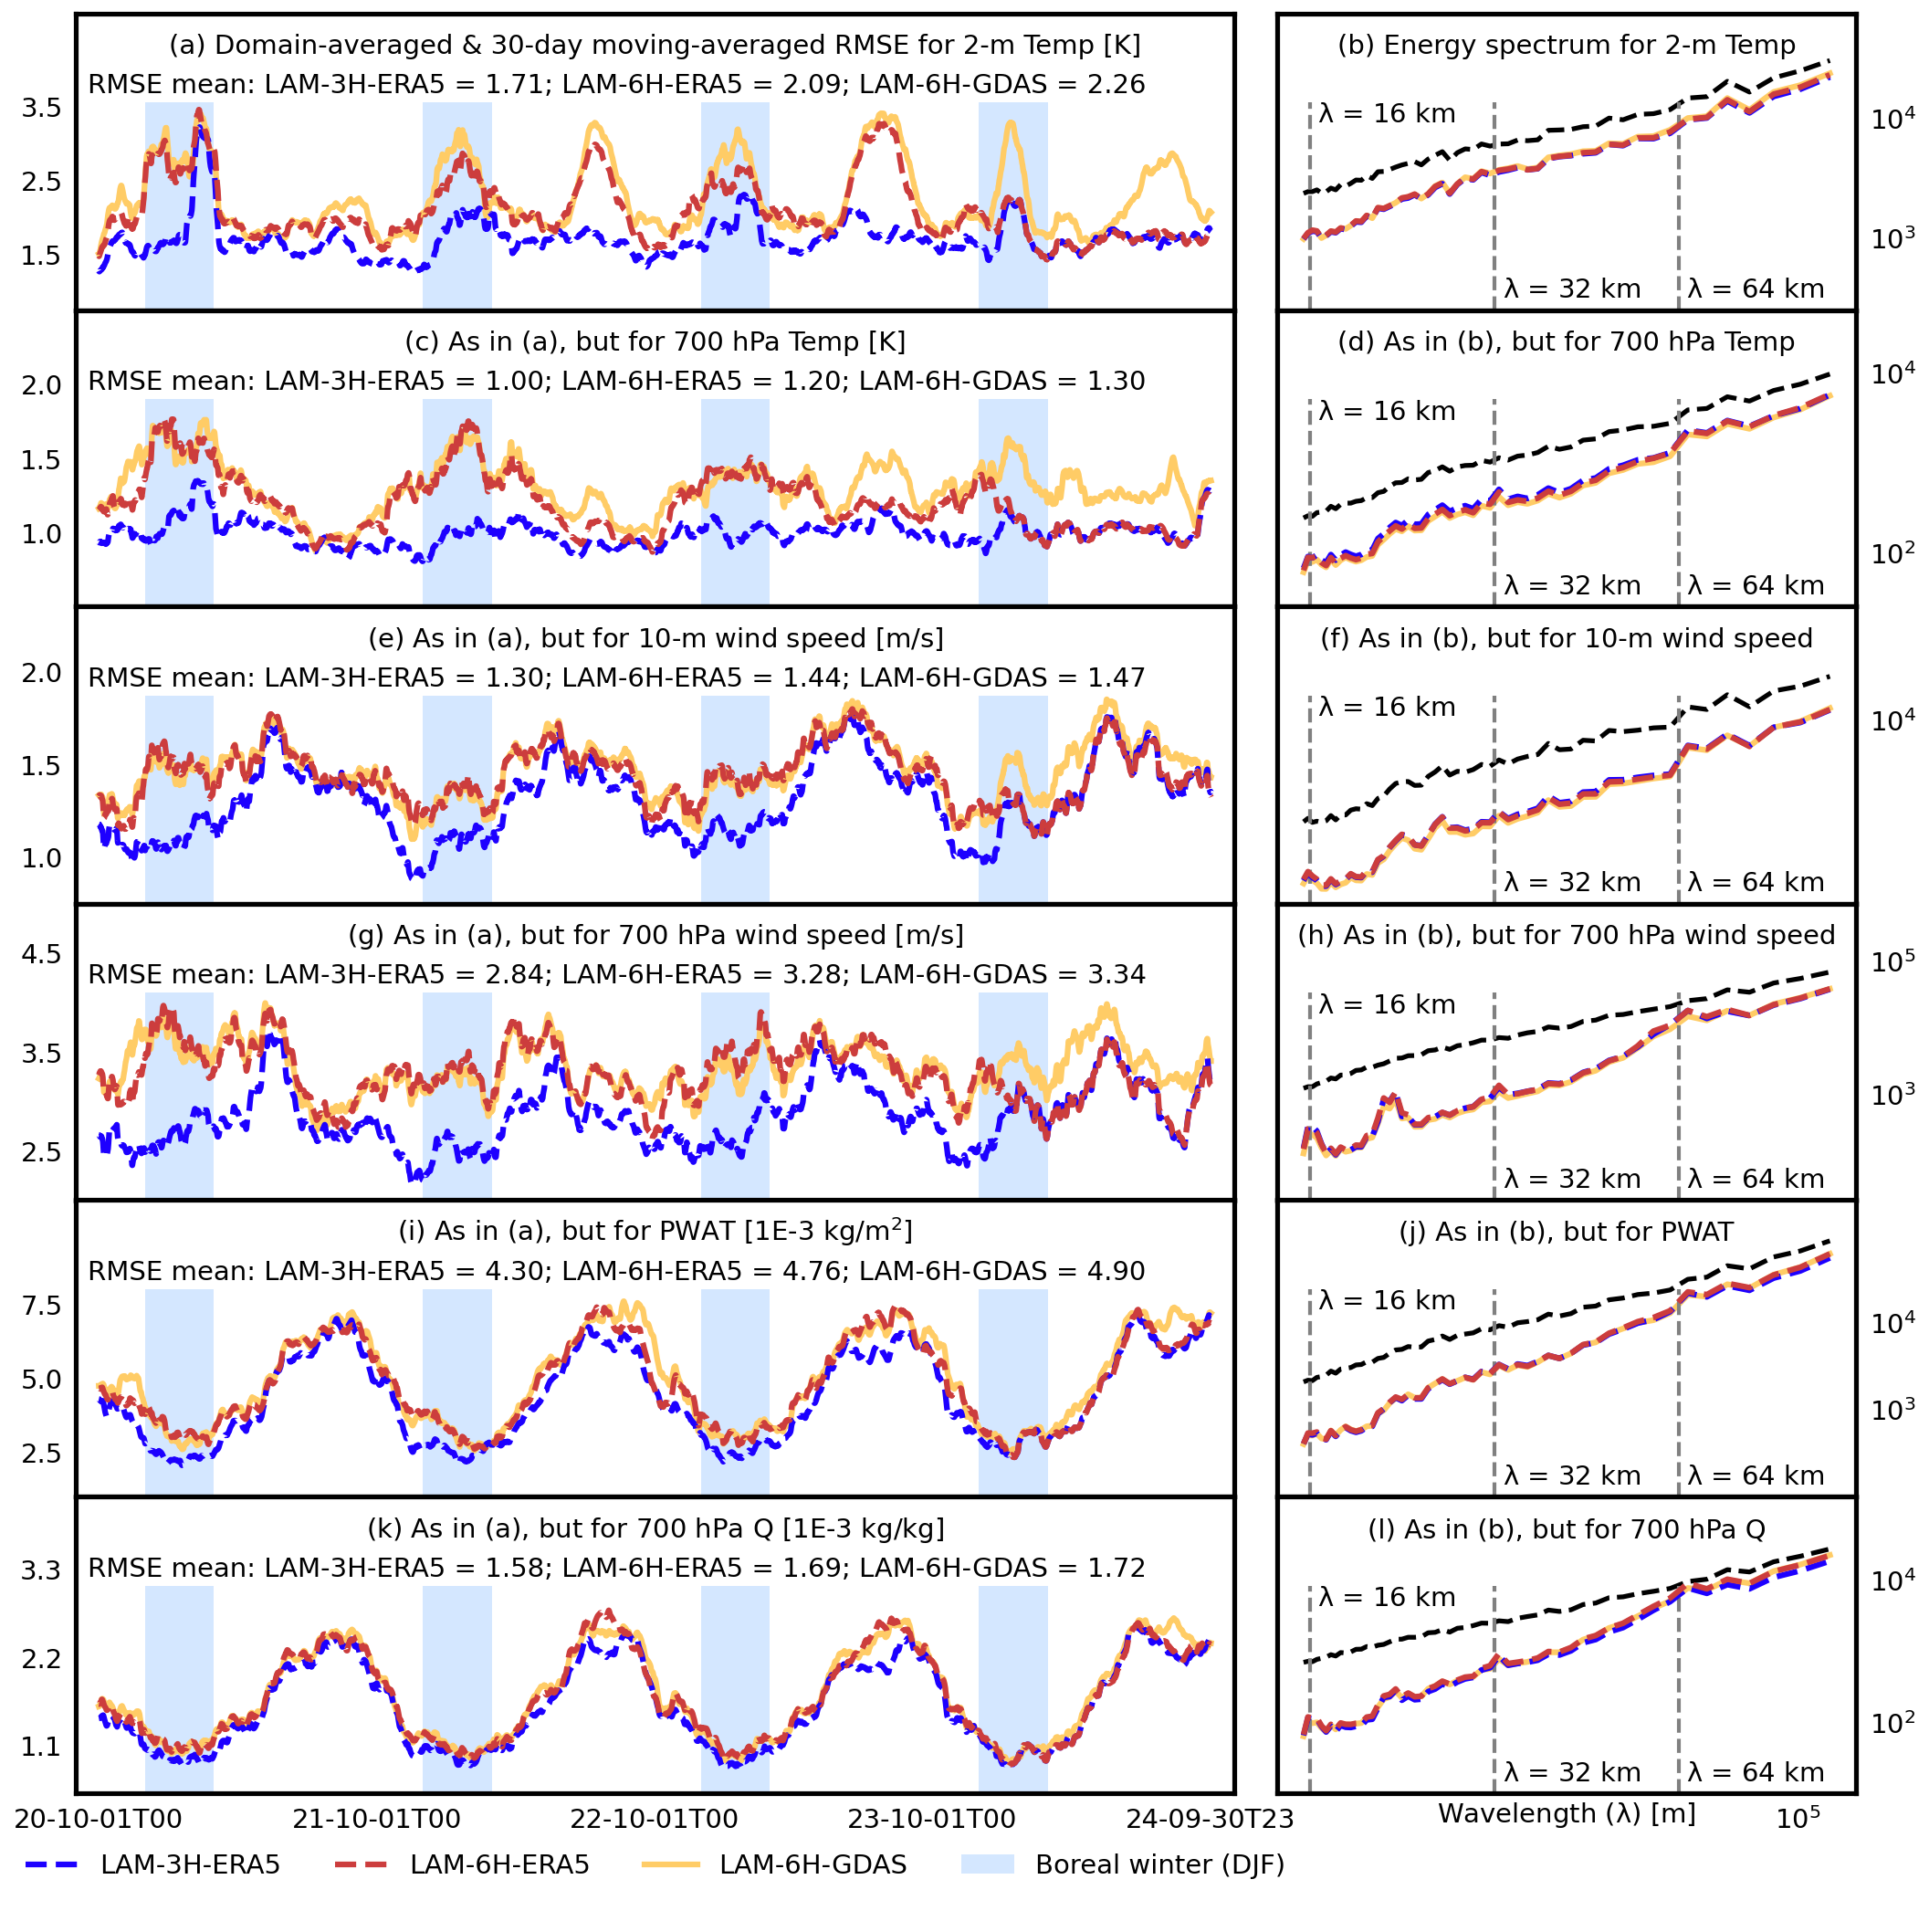

In [18]:
fig = plt.figure(figsize=(13, 13), dpi=dpi_)
gs = gridspec.GridSpec(6, 2, height_ratios=[1,]*6, width_ratios=[1, 0.5])

AX_lines = []
AX_zes = []
for i in range(6):
    AX_lines.append(plt.subplot(gs[i, 0]))
    AX_zes.append(plt.subplot(gs[i, 1]))

for ax in AX_zes + AX_lines:
    ax = gu.ax_decorate_box(ax)

for ax in AX_lines:
    ax.tick_params(labelleft=True, labelsize=14)

AX_lines[-1].tick_params(labelbottom=True, labelsize=14)

for ax in AX_zes:
    ax.tick_params(labelright=True, labelsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')

AX_zes[-1].tick_params(labelbottom=True, labelsize=14)

# plt.subplots_adjust(0, 0, 1, 1, hspace=0.2, wspace=0.05)
plt.subplots_adjust(0, 0, 1, 1, hspace=0., wspace=0.05)

title_lines = [
    '(a) Domain-averaged & 30-day moving-averaged RMSE for 2-m Temp [K]', 
    '(c) As in (a), but for 700 hPa Temp [K]', 
    '(e) As in (a), but for 10-m wind speed [$\mathsf{m/s}$]',
    '(g) As in (a), but for 700 hPa wind speed [$\mathsf{m/s}$]',
    '(i) As in (a), but for PWAT [1E-3 $\mathsf{kg/m^{2}}$]', # $\mathsf{10^{-3}}$ 
    '(k) As in (a), but for 700 hPa Q [1E-3 $\mathsf{kg/kg}$]'
]


title_zes = [
    '(b) Energy spectrum for 2-m Temp', 
    '(d) As in (b), but for 700 hPa Temp', 
    '(f) As in (b), but for 10-m wind speed',
    '(h) As in (b), but for 700 hPa wind speed',
    '(j) As in (b), but for PWAT',
    '(l) As in (b), but for 700 hPa Q'
]

scales = [1, 1, 1, 1, 1e3, 1e3]
YLIMs = [[0.75, 4.75], [0.5, 2.5], [0.75, 2.35], [2, 5], [1, 11], [0.5, 4.2]]
YTICKS = [
    [1.5, 2.5, 3.5], [1.0, 1.5, 2.0],
    [1, 1.5, 2,], [2.5, 3.5, 4.5],
    [2.5, 5.0, 7.5], [1.1, 2.2, 3.3]
]

X_TICKS = np.array([
    np.datetime64('2020-10-01T00'),
    np.datetime64('2021-10-01T00'), 
    np.datetime64('2022-10-01T00'), 
    np.datetime64('2023-10-01T00'), 
    np.datetime64('2024-09-30T23')])

for i_var, varname in enumerate(varname_plot):
    for i_exp, exp_name in enumerate(['B3H', 'B6H', 'GDAS']):

        temp_mean = []
        temp_std = []
        
        AX_lines[i_var].plot(time_hourly, scales[i_var]*dict_RMSE[f'{exp_name}_{varname}_ave'], **line_keys[exp_name])

    AX_lines[i_var].axvspan(
        np.datetime64('2020-12-01T00'),
        np.datetime64('2021-03-01T00'), 
        color=cyan, linewidth=0, alpha=0.25, ymin=0, ymax=0.7, zorder=1)

    AX_lines[i_var].axvspan(
        np.datetime64('2021-12-01T00'),
        np.datetime64('2022-03-01T00'), 
        color=cyan, linewidth=0, alpha=0.25, ymin=0, ymax=0.7, zorder=1)

    AX_lines[i_var].axvspan(
        np.datetime64('2022-12-01T00'),
        np.datetime64('2023-03-01T00'), 
        color=cyan, linewidth=0, alpha=0.25, ymin=0, ymax=0.7, zorder=1)

    AX_lines[i_var].axvspan(
        np.datetime64('2023-12-01T00'),
        np.datetime64('2024-03-01T00'), 
        color=cyan, linewidth=0, alpha=0.25, ymin=0, ymax=0.7, zorder=1)
    
    AX_lines[i_var].text(
        0.01, 0.8, 
        'RMSE mean: LAM-3H-ERA5 = {:.2f}; LAM-6H-ERA5 = {:.2f}; LAM-6H-GDAS = {:.2f}'.format(
            scales[i_var]*dict_RMSE[f'B3H_{varname}_mean'], 
            scales[i_var]*dict_RMSE[f'B6H_{varname}_mean'], 
            scales[i_var]*dict_RMSE[f'GDAS_{varname}_mean']),
    fontsize=14, ha='left', va='top', transform=AX_lines[i_var].transAxes)
    
    AX_lines[i_var].set_title(title_lines[i_var], fontsize=14, y=0.825)
    AX_lines[i_var].set_ylim(YLIMs[i_var])
    AX_lines[i_var].set_yticks(YTICKS[i_var])
    # AX_lines[i_var].set_xlim([time_hourly[0], time_hourly[-1]])
    AX_lines[i_var].set_xlim([np.datetime64('2020-09-01T00'), np.datetime64('2024-10-30T23')])
    
    if i_var == 5:
        AX_lines[i_var].set_xticks(X_TICKS)
        
        AX_lines[i_var].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%dT%H'))
        # AX_lines[i_var].tick_params(axis='x', labelrotation=45)

# for i in range(2):
#     AX_lines[4+i].text(0.01, 0.92, '[1E-3]', fontsize=14, ha='left', va='top', transform=AX_lines[4+i].transAxes)


# YLIMs = [[1e3, 7.5e5], [1e3, 5e5], [1e3, 7.5e5], [2e3, 2e6], [1e-2, 2e0], [3e-4, 9e-1]]
# YTICKS = [
#     [1e4, 1e5], [1e4, 1e5],
#     [1e4, 1e5], [1e4, 1e5],
#     [1e-1, 1e0], [1e-3, 1e-2, 1e-1]
# ]

YLIMs = [[2.5e2, 7.5e4], [2.5e1, 5e4], [7.5e2, 5e4], [2.5e1, 7.5e5], [1e2, 2.5e5], [1e1, 1.5e5]]
YTICKS = [
    [1e3, 1e4], [1e2, 1e4],
    [1e4], [1e3, 1e5],
    [1e3, 1e4], [1e2, 1e4]
]

X_VLIME = [16000, 32000, 64000]

for i_var, varname in enumerate(varname_plot):
    for exp_name in ['B3H', 'B6H', 'GDAS', 'target']:
        # cut too small and too big wavelength
        AX_zes[i_var].plot(
            dict_ZES[f'{exp_name}_lambda'][106:-8], 
            dict_ZES[f'{exp_name}_{varname}_zes'][106:-8], **line_keys[exp_name])

    AX_zes[i_var].set_ylim(YLIMs[i_var])
    AX_zes[i_var].set_yticks(YTICKS[i_var])
    AX_zes[i_var].set_title(title_zes[i_var], fontsize=14, y=0.825)
    
    # AX_zes[i_var].set_ylabel('Spectral power', fontsize=14)
    # AX_zes[i_var].yaxis.set_label_position("right")
    
    for x_vline in X_VLIME:
        AX_zes[i_var].axvline(x=x_vline, color='0.5', linestyle='--', linewidth=2, ymin=0.0, ymax=0.7)

    AX_zes[i_var].text(
        0.07, 0.7, '$\mathsf{\lambda}$ = 16 km', 
        ha='left', va='top', fontsize=14, transform=AX_zes[i_var].transAxes)

    AX_zes[i_var].text(
        0.375+0.015, 0.025, '$\mathsf{\lambda}$ = 32 km', 
        ha='left', va='bottom', fontsize=14, transform=AX_zes[i_var].transAxes)

    AX_zes[i_var].text(
        0.681+0.025, 0.024, '$\mathsf{\lambda}$ = 64 km', 
        ha='left', va='bottom', fontsize=14, transform=AX_zes[i_var].transAxes)

AX_zes[-1].set_xlabel('Wavelength ($\mathsf{\lambda}$) [m]', fontsize=14, labelpad=-18)

handle_legneds1 = []
handle_legneds1.append(mlines.Line2D([], [], **line_keys['B3H']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['B6H']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['GDAS']))
handle_legneds1.append(patches.Patch(facecolor=cyan, alpha=0.25, linewidth=0, label=' '))

ax_lg1 = fig.add_axes([-0.035, -0.07, 0.728, 0.05])
LG1 = ax_lg1.legend(
    handle_legneds1, 
    ['LAM-3H-ERA5', 'LAM-6H-ERA5', 'LAM-6H-GDAS', 'Boreal winter (DJF)'], 
    bbox_to_anchor=(1, 1), ncol=4, prop={'size':14}
)

LG1 = gu.lg_box(LG1)
ax_lg1.set_axis_off()